In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/ABIDE/") 

Mounted at /content/drive


In [ ]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install torch-geometric
import torch
print(torch.__version__)  
print(torch.version.cuda)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 58.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.0+cu116
    Uninstalling torchaudio-0.13.0+cu116:
      Successfully uninstalled torchaudio-0.13.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

1.11.0+cu102
10.2


In [ ]:
# load ComBat algorithm
# !python /content/drive/MyDrive/ABIDE/neuralCombat.py 
import sys
sys.path.append('/content/drive/MyDrive/ABIDE/')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from neuralCombat import *
# from neuralCombat.py import neuralCombat
import pandas as pd
from sklearn import svm
import joblib
import openpyxl
from openpyxl import load_workbook
import os
import scipy.io as scio
import argparse
import numpy as np
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from os.path import join
from os import listdir
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader
from collections import OrderedDict
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
from os import path
import shutil
import scipy.stats
import scipy.ndimage
import random
import torch.nn.init as init
import torch.nn.functional as F
import sys
import math
from functools import reduce
import operator
from scipy.interpolate import interp1d
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def feature_selection_fMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection 

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector
def feature_selection_sMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection 

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=10, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector

def get_index(lst=None, item=''):
	return [i for i in range(len(lst)) if lst[i] == item]

def flatten_one(length, img):
	'''
	  In some situations, the dimension on z-axis of images are smaller than
	  the dimension of z-axis of patches, this function will be used to pad
	'''

	one_line = np.zeros((1, int(length)))
	position = 0
	for i in range(img.shape[0]):  # column
		for j in range(i + 1, img.shape[1]):  # row
			one_line[0, position] = img[j, i]
			position = position + 1
	return one_line


def get_ids(num_subjects=None,dir_path=''):
	"""
	return:
		subject_IDs    : list of all subject IDs
	"""
	subject_IDs = np.genfromtxt(os.path.join(dir_path, 'subject_IDs.txt'), dtype=str)

	if num_subjects is not None:
		subject_IDs = subject_IDs[:num_subjects]

	return subject_IDs

def save_model(net,path, name_net):

  # This fucntion is used to save a specific model

    path_net =  path + '/' + name_net + '.pth'
    torch.save(net.cpu().state_dict(), path_net)
    net.cuda()

def load_model(net, path, name_net):

  # This function is used to load a specific model we saved before

    path_net =  path + '/' + name_net + '.pth'
    net.load_state_dict(torch.load(path_net))

    return net



In [ ]:
########################################### Load Data ###############################################
#####################################################################################################
#####################################################################################################
fMRI_atlas = 'CC200'  # AAL or CC200
combat_fMRI = True    # True or False
combat_sMRI = True

if combat_sMRI == False:
  save_combat_sMRI = '/without_ComBat/'
else:
  save_combat_sMRI = '/with_ComBat/'

# fMRI path
save_path = '/content/drive/MyDrive/ABIDE/save_models/CC200_sMRI/'+ save_combat_sMRI
root_path_fMRI = '/content/dataset'
if os.path.exists(root_path_fMRI):
  shutil.rmtree(root_path_fMRI) 
shutil.copytree('/content/drive/MyDrive/ABIDE/' + fMRI_atlas + '/original/', root_path_fMRI) 
label_dir = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality'

# sMRI path
localDir = '/content/sMRI_dataset/'
if os.path.exists(localDir):
  shutil.rmtree(localDir) 
os.makedirs(localDir)
!unzip '/content/drive/MyDrive/ABIDE/freesurfer_stats.zip' -d '/content/sMRI_dataset'
localDir = localDir + 'freesurfer_stats/'


k_fold = 5
new_number_features_fMRI = 5000
new_number_features_sMRI = 1435
new_number_features_combine = 6000
number_samples = 871
useless_samples = ['51334']
if fMRI_atlas == 'AAL':
  image_size = [116, 116]
else:
  image_size = [200, 200]
scaler = True


age_name = 'ages.mat'
gender_name = 'genders.mat'
label_name = 'ABIDE_label_871.mat'
label = scio.loadmat(os.path.join(label_dir, label_name))
label = label['label'][0]
labels = np.zeros(number_samples - len(useless_samples))
site_name = 'sites.mat'
site = scio.loadmat(os.path.join(label_dir, site_name))
all_sites = site['sites']
for i in range(len(all_sites)):
	site = all_sites[i]
	all_sites[i] = site.replace(' ', '')
unique_sites = np.unique(all_sites)
sites = []
unique_sites = list(unique_sites)

gender = scio.loadmat(os.path.join(label_dir, gender_name))
gender = gender['genders']
genders = np.zeros((number_samples - len(useless_samples), 1))

age = scio.loadmat(os.path.join(label_dir, age_name))
age = age['ages']
ages = np.zeros((number_samples - len(useless_samples), 1))

subject_IDs = get_ids(number_samples,dir_path=label_dir)
subject_IDs = subject_IDs.tolist()
length = image_size[0] * (image_size[1]-1) / 2
fMRI_images = np.zeros((number_samples - len(useless_samples), int(length)))

position = 0
print('constructing fMRI features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    image_name = subject_name + '.mat'
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    image = scio.loadmat(os.path.join(root_path_fMRI, image_name))
    img = image['connectivity']

    idx = np.triu_indices_from(img, 1)
    fMRI_images[position, :] = img[idx]
    sites.append(all_sites[subject_index[0]])
    labels[position] = label[subject_index[0]]
    genders[position] = int(gender[subject_index[0]]) + 1
    ages[position] = float(age[subject_index[0]].replace(' ', ''))
    position = position + 1

if scaler == True:
	fMRI_images = StandardScaler().fit_transform(fMRI_images)

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/brainvol.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.pial.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.thresh.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.curv.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.w-g.pct.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.pial.stats  
  inflating: /c

In [ ]:
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load Desikan_Killiany_features
left = 'lh.aparc.stats'
right = 'rh.aparc.stats'
number_roi = 68
feature_list = ['NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
names = ['StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
skiprows= list(range(0,61))
Desikan_Killiany_features = np.zeros((number_samples - len(useless_samples), number_roi * len(feature_list)))


position = 0
print('constructing Desikan-Killiany Atlas features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    table_left = pd.read_table(localDir + subject_name + '/' + left, sep='\s+', names=names,
						  skiprows=skiprows)
    table_right = pd.read_table(localDir + subject_name + '/' + right, sep='\s+', names=names,
						  skiprows=skiprows)

    for j in range(len(feature_list)):
      feature_name = feature_list[j]
      left_features = table_left[feature_name].values.tolist()
      right_features = table_right[feature_name].values.tolist()
      all_features = left_features + right_features
      if len(all_features) != number_roi:
       print('The sample ' + subject_name + ' has mistake!')
      all_features = np.array(all_features)
      Desikan_Killiany_features[position, j*number_roi : (j+1)*number_roi] = all_features
    position = position + 1

if scaler == True:
	for i in range(len(feature_list)):
		Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi] = StandardScaler().fit_transform(Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi])

print('finished')

############################################### Load aseg features
print('constructing aseg features')
number_roi_aseg = 45
aseg = 'aseg.stats'
feature_list_aseg = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_aseg = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_aseg= list(range(0,79))
aseg_features = np.zeros((number_samples - len(useless_samples), number_roi_aseg * len(feature_list_aseg)))

position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + aseg, sep='\s+', names=names_aseg,
						  skiprows=skiprows_aseg)
		for j in range(len(feature_list_aseg)):
			feature_name = feature_list_aseg[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_aseg:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			aseg_features[position, j*number_roi_aseg : (j+1)*number_roi_aseg] = all_features
		position = position + 1

if scaler == True:
	for i in range(len(feature_list_aseg)):
		aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg] = StandardScaler().fit_transform(aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg])
print('finished')

############################################### Load wmparc features
number_roi_wmparc = 70
wmparc = 'wmparc.stats'
feature_list_wmparc = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_wmparc = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_wmparc= list(range(0,65))
wmparc_features = np.zeros((number_samples - len(useless_samples), number_roi_wmparc * len(feature_list_wmparc)))

print('constructing wmparc features')
position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + wmparc, sep='\s+', names = names_wmparc,
						  skiprows=skiprows_wmparc)
		for j in range(len(feature_list_wmparc)):
			feature_name = feature_list_wmparc[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_wmparc:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			wmparc_features[position, j*number_roi_wmparc : (j+1)*number_roi_wmparc] = all_features
		position = position + 1
if scaler == True:
	for i in range(len(feature_list_wmparc)):
		wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc] = StandardScaler().fit_transform(wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc])
print('finished')

############################################### concatenation
sMRI_features = np.concatenate((Desikan_Killiany_features, aseg_features, wmparc_features),axis = 1)

constructing Desikan-Killiany Atlas features
The index for sample 51334 is :  [799]
finished
constructing aseg features
The index for sample 51334 is :  [799]
finished
constructing wmparc features
The index for sample 51334 is :  [799]
finished


(870, 1417)
(870, 19900)
[[-0.26379633 -0.36585841  0.05890851 ... -1.11697067 -0.75921467
  -1.26821845]
 [ 0.06295102 -0.10354483  0.33562979 ... -1.05248729 -0.25577202
  -0.43539667]
 [ 0.42528471  0.95491346 -0.04689668 ... -0.60110366 -0.12991135
  -0.22719123]
 ...
 [-0.3026178  -0.9917294  -0.14781855 ... -0.98800391  0.24767064
   1.36905051]
 [-1.29903544 -0.89508755 -1.63560233 ...  0.68856387  1.69506827
   0.67503236]
 [ 0.02412955  0.81225169 -0.29594582 ...  0.68856387 -0.19284168
   0.46682692]]
[[ 1.88061923  1.93466056  0.63599984 ...  1.46885436  1.98724053
   1.1636311 ]
 [ 0.66500812 -0.06661812 -0.205227   ... -0.2077196   1.01585943
  -0.42020151]
 [ 0.10988633  1.25041509  0.03347263 ...  0.58907048  0.07775594
  -0.27915372]
 ...
 [-1.36387375 -0.51655671 -0.33001366 ... -0.03915398 -0.87802826
  -1.38083403]
 [-1.53608071 -1.77684322 -0.2103792  ...  0.22321413 -0.14141626
  -0.94863806]
 [-0.10758455  0.20114007  1.34416595 ... -0.14711034  1.47870214
  -0.14

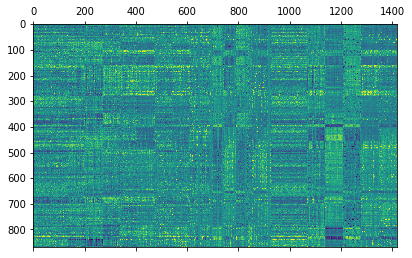

In [ ]:
print(sMRI_features.shape)
print(fMRI_images.shape)
print(sMRI_features)
print(fMRI_images)
plt.matshow(sMRI_features, vmin=-4, vmax=4)
plt.show()

In [ ]:
############################################### Combat ###############################################################
############################################### Combat ###############################################################
############################################### Combat ###############################################################

batch = []
for i in range(len(sites)):
	batch.append(get_index(lst=unique_sites, item=sites[i])[0]+1)

combat_labels = []
combat_genders = []
combat_ages = []
for i in range(len(labels)):
	combat_labels.append(labels[i] + 1)
	combat_genders.append(genders[i])
	combat_ages.append(ages[i])
 
if combat_fMRI == True:
	print('The ComBat for fMRI')
	new_all_samples_feature = fMRI_images.T
	covars = {}
	covars['batch'] = batch
	covars['labels'] = combat_labels
	covars['genders'] = combat_genders
	covars['ages'] = combat_ages
	covars = pd.DataFrame(covars)

	# To specify names of the variables that are categorical:
	categorical_cols = ['labels', 'genders']
	# To specify the name of the variable that encodes for the scanner/batch covariate:
	batch_col = 'batch'
	continuous_cols = ['ages']
	# Harmonization step:
	new_all_samples_feature = neuroCombat(dat=new_all_samples_feature,
											covars=covars,
											batch_col=batch_col,
											categorical_cols=categorical_cols,
											continuous_cols=continuous_cols)["data"]
	fMRI_images = new_all_samples_feature.T

if combat_sMRI == True:
	print('The ComBat for sMRI')
	new_all_samples_feature = sMRI_features.T
	covars = {}
	covars['batch'] = batch
	covars['labels'] = combat_labels
	covars['genders'] = combat_genders
	covars['ages'] = combat_ages
	covars = pd.DataFrame(covars)

	# To specify names of the variables that are categorical:
	categorical_cols = ['labels', 'genders']
	# To specify the name of the variable that encodes for the scanner/batch covariate:
	batch_col = 'batch'
	continuous_cols = ['ages']
	# Harmonization step:
	new_all_samples_feature = neuroCombat(dat=new_all_samples_feature,
											covars=covars,
											batch_col=batch_col,
											categorical_cols=categorical_cols,
											continuous_cols=continuous_cols)["data"]
	sMRI_features = new_all_samples_feature.T



The ComBat for fMRI
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
The ComBat for sMRI
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


/content/drive/MyDrive/ABIDE/neuralCombat.py:325: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


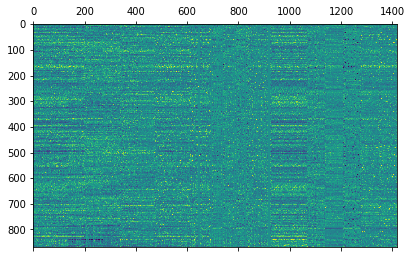

In [ ]:
plt.matshow(sMRI_features, vmin=-4, vmax=4)
plt.show()

In [ ]:
############################################### phenotypic ###############################################################
############################################### phenotypic ###############################################################
############################################### phenotypic ###############################################################
ages_name = 'ages.mat'
ages = scio.loadmat(os.path.join(label_dir, ages_name))
ages = ages['ages']

gender_name = 'genders.mat'
genders = scio.loadmat(os.path.join(label_dir, gender_name))
genders = genders['genders']

FIQ_name = 'FIQS.mat'
FIQS = scio.loadmat(os.path.join(label_dir, FIQ_name))
FIQS = FIQS['FIQS']

NUM_name = 'NUM.mat'
NUM = scio.loadmat(os.path.join(label_dir, NUM_name))
NUMS = NUM['NUM']

PEC_name = 'PEC.mat'
PEC = scio.loadmat(os.path.join(label_dir, PEC_name))
PECS = PEC['PEC']

RAT_name = 'RAT.mat'
RAT = scio.loadmat(os.path.join(label_dir, RAT_name))
RATS = RAT['RAT']

age = np.zeros((number_samples - len(useless_samples), 1))
gender = np.zeros((number_samples - len(useless_samples), 1))
FIQ = np.zeros((number_samples - len(useless_samples), 1))
NUM = np.zeros((number_samples - len(useless_samples), 1))
PEC = np.zeros((number_samples - len(useless_samples), 1))
RAT = np.zeros((number_samples - len(useless_samples), 1))

position = 0
print('constructing phenotypic features')
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		age[position] = float(ages[subject_index[0]].replace(' ', ''))
		gender[position] = int(genders[subject_index[0]]) + 1
		FIQ[position] = int(FIQS[subject_index[0]])
		NUM[position] = float(NUMS[subject_index[0]])
		PEC[position] = float(PECS[subject_index[0]])
		RAT[position] = int(RATS[subject_index[0]])
		position = position + 1
FIQ[FIQ == -9999] = 108

if scaler == True:

  age[:,0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(age[:,0], axis = 1)))
  FIQ[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(FIQ[:, 0], axis = 1)))
  NUM[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(NUM[:, 0], axis = 1)))
  PEC[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(PEC[:, 0], axis = 1)))

# age, gender, FIQ, NUM, PEC, RAT
for i in range(3):
	sMRI_features = np.concatenate((sMRI_features, age, gender, FIQ, NUM, PEC, RAT),axis = 1)


constructing phenotypic features
The index for sample 51334 is :  [799]


In [ ]:
dist_train = {}
dist_validation = {}
dist_test = {}
for i in range(k_fold):
	dist_train[str(i + 1)] = []
	dist_validation[str(i + 1)] = []
	dist_test[str(i + 1)] = []

for each_site in unique_sites:
	index_site = get_index(sites, each_site)
	label = np.zeros((len(index_site)))
	for i in range(len(index_site)):
		index = index_site[i]
		label[i] = int(labels[int(index)])
	########################################### StratifiedKFold ####################################################
	sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
	group = 0
	for train, validation in sfolder.split(index_site,label):
		for i in train:
			dist_train[str(group + 1)].append(index_site[i])
			name = 0
		for j in validation:
			dist_validation[str(group + 1)].append(index_site[j])
			name = 0
		group = group+1

	group = 0
	for train, validation in sfolder.split(index_site,label):
		if group == 0:
			for j in validation:
				dist_test[str(group + k_fold)].append(index_site[j])
				dist_train[str(group + k_fold)].remove(index_site[j])
		else:
			for j in validation:
				dist_test[str(group)].append(index_site[j])
				dist_train[str(group)].remove(index_site[j])
		group = group+1


for i in range(k_fold):
	print(len(dist_test[str(i+1)]))

177
174
170
167
182


In [ ]:
import torch.nn as nn
import torch_geometric as tg

############################################### GCN model ###############################################################
############################################### GCN model ###############################################################
############################################### GCN model ###############################################################

class GCN(nn.Module):
    def __init__(self, in_c, hid_c, out_c, K, dropout_rate, normalize=True):
        """
        :param in_c: int, number of input channels.
        :param hid_c: int, number of hidden channels.
        :param out_c: int, number of output channels.
        :param K:
        """
        super(GCN, self).__init__()
        self.normalize = normalize

        self.conv1 = tg.nn.ChebConv(in_c, hid_c, K, normalization='sym', bias=True)
        self.conv2 = tg.nn.ChebConv(hid_c, hid_c, K, normalization='sym', bias=True)
        self.conv3 = tg.nn.ChebConv(hid_c, out_c, K, normalization='sym', bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, data, edge_index, edgenet_input):

        edge_weight = torch.squeeze(edgenet_input)
        # data = self.dropout(data)
        h = self.relu(self.dropout(self.conv1(data, edge_index, edge_weight)))
        h = self.relu(self.dropout(self.conv2(h, edge_index, edge_weight)))
        h = self.conv3(h, edge_index, edge_weight)

        return self.softmax(h)


In [ ]:
############################################### Population graph ###############################################################
############################################### Population graph ###############################################################
############################################### Population graph ###############################################################
def get_subject_score(subject_list,l, path, all_subject_list):

    name = l + '.mat'
    file = scio.loadmat(os.path.join(path, name))
    file = file[l]
    label_dict = {}
    for i in subject_list:
        sample_index = get_index(lst=all_subject_list, item=i)
        value = file[sample_index[0]]
        if l == 'genders':
            label_dict[i] = int(value)
        elif l == 'ages':
            label_dict[i] = float(value)
        elif l == 'FIQS':
            label_dict[i] = float(value)
        elif l == 'NUM':
            label_dict[i] = int(value)
        elif l == 'PEC':
            label_dict[i] = float(value)
        elif l == 'RAT':
            label_dict[i] = int(value)
        elif l == 'sites':
            label_dict[i] = value.replace(' ', '')
        else:
            label_dict[i] = value
    return label_dict

def create_graph_from_scores(scores, subject_list, path, all_subject_list):
    """
        scores       : list of phenotypic information to be used to construct the affinity graph
        subject_list : list of subject IDs
    return:
        graph        : adjacency matrix of the population graph (num_subjects x num_subjects)
    """

    num_nodes = len(subject_list)
    graph = np.zeros((num_nodes, num_nodes))

    for l in scores:
        label_dict = get_subject_score(subject_list, l, path, all_subject_list)

        # quantitative phenotypic scores
        if l in ['ages']:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    try:
                        val = abs(float(label_dict[subject_list[k]]) - float(label_dict[subject_list[j]]))
                        if val < 2:
                            graph[k, j] += 1
                            graph[j, k] += 1
                    except ValueError:  # missing label
                        pass
        elif l in ['FIQ']:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    try:
                        val = abs(float(label_dict[subject_list[k]]) - float(label_dict[subject_list[j]]))
                        if val < 10:
                            graph[k, j] += 1
                            graph[j, k] += 1
                    except ValueError:  # missing label
                        pass

        else:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    if label_dict[subject_list[k]] == label_dict[subject_list[j]]:
                        graph[k, j] += 1
                        graph[j, k] += 1

    return graph

GCN_labels = np.zeros((number_samples - len(useless_samples), 2))
for i in range(len(labels)):
    if labels[i] == 1:
        GCN_labels[i,0] = 1
    else:
        GCN_labels[i,1] = 1


all_subject_IDs = get_ids(number_samples,dir_path=label_dir)
all_subject_IDs = all_subject_IDs.tolist()
for i in useless_samples:
    subject_IDs.remove(i)

graph = create_graph_from_scores(['sites'], subject_IDs, label_dir,all_subject_IDs)



In [ ]:
data = {}
for fold in range(1, k_fold+1):
  data[str(fold)] = []
  selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
  selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

  new_fMRI_data = selector_fMRI.transform(fMRI_images)
  new_sMRI_data = selector_sMRI.transform(sMRI_features)
  ################################################# combine ##########################################
  sMRI_fMRI_combine = np.concatenate((new_sMRI_data, new_fMRI_data), axis = 1)
  selector_combine = feature_selection_fMRI(sMRI_fMRI_combine, labels, dist_train[str(fold)], new_number_features_combine)
  fold_data = selector_combine.transform(sMRI_fMRI_combine)

  n = fold_data.shape[0]
  num_edge = n * n
  edge_index = np.zeros([2, num_edge], dtype=np.int64)
  edgenet_input = np.zeros([num_edge, 1], dtype=np.float32) 
  aff_score = np.zeros(num_edge, dtype=np.float32)
  flatten_ind = 0

  for i in range(n): 
    for j in range(n):
      edge_index[:, flatten_ind] = [i, j]
      edgenet_input[flatten_ind] = graph[i,j]
      aff_score[flatten_ind] = graph[i,j]
      flatten_ind += 1


  keep_ind = np.where(aff_score > 0.99)[0]
  edge_index = edge_index[:, keep_ind]
  edgenet_input = edgenet_input[keep_ind]

  data[str(fold)].append(fold_data)
  data[str(fold)].append(GCN_labels)
  data[str(fold)].append(edge_index)
  data[str(fold)].append(edgenet_input)

Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

In [ ]:
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
def train_GCN(args, model, all_data, fold_train_index, fold_validation_index, fold_test_index, scheduler):

    model.train()
    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=True)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=True)
    edgenet_input = edgenet_input.float()
    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    scheduler.zero_grad()
    out = model(data, edge_index, edgenet_input)
    out = out[fold_train_index,:]  
    target = target[fold_train_index, :]

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1]) # only train set will be included
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    cross_loss.backward()
    scheduler.step()

    ############################## validation and test ################################################################################
    val_target, val_out, val_loss = validation_GCN(args, model, all_data, fold_validation_index)
    test_target, test_out, test_out_prob, test_loss = test_GCN(args, model, all_data, fold_test_index)

    return model, target, out, cross_loss.item(), val_target, val_out,val_loss, test_target, test_out, test_out_prob, test_loss

    
def validation_GCN(args, model,all_data,  fold_validation_index):

    model.eval()
    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out = model(data, edge_index, edgenet_input)
    out = out[fold_validation_index, :]
    target = target[fold_validation_index, :]
    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()

    return target, out, cross_loss.item()


def test_GCN(args, model, all_data,  fold_test_index):

    model.eval()

    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out = model(data, edge_index, edgenet_input)
    out = out[fold_test_index, :]
    target = target[fold_test_index, :]
    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()

    return target, out, out_prob, cross_loss.item()



In [ ]:
########################################### Training setting ################################################
########################################### Training setting ################################################
########################################### Training setting ################################################
torch.cuda.empty_cache()
parser = argparse.ArgumentParser()
parser.add_argument('--ngpu', type=int, default=1)
parser.add_argument('--nEpochs', type=int, default=200)
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--weight-decay', '--wd', default=1e-8, type=float,
                    metavar='W', help='weight decay (default: 1e-8)')
parser.add_argument('--no-cuda', action='store_true')
parser.add_argument('--opt', type=str, default='adam')
parser.add_argument('--lr', type=str, default=8e-4)
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--cheby_order_K', type=int, default=2)
parser.add_argument('--input_dimension', type=int, default=new_number_features_combine)
parser.add_argument('--hidden_dimension', type=int, default=128)
parser.add_argument('--output_dimension', type=int, default=2)
parser.add_argument('--dropout_rate', type=int, default=0.3)
    
#
args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    
gpu_ids = range(args.ngpu)
train = train_GCN


  + Number of params: 1569538
Save models
Train Epoch: 1: train loss : 0.90887189	 train accuracy : 0.52641879	 val accuracy : 0.63186813	 test accuracy : 0.61581921	
Train Epoch: 2: train loss : 0.64497519	 train accuracy : 0.70058708	 val accuracy : 0.56593407	 test accuracy : 0.55932203	
Train Epoch: 3: train loss : 0.85698402	 train accuracy : 0.65753425	 val accuracy : 0.62637363	 test accuracy : 0.62711864	
Save models
Train Epoch: 4: train loss : 0.51513100	 train accuracy : 0.78669276	 val accuracy : 0.64835165	 test accuracy : 0.64971751	
Save models
Train Epoch: 5: train loss : 0.43913719	 train accuracy : 0.81017613	 val accuracy : 0.69230769	 test accuracy : 0.63276836	
Train Epoch: 6: train loss : 0.30475357	 train accuracy : 0.86692759	 val accuracy : 0.68681319	 test accuracy : 0.63841808	
Save models
Train Epoch: 7: train loss : 0.34644181	 train accuracy : 0.86888454	 val accuracy : 0.75824176	 test accuracy : 0.67796610	
Train Epoch: 8: train loss : 0.22602788	 train 

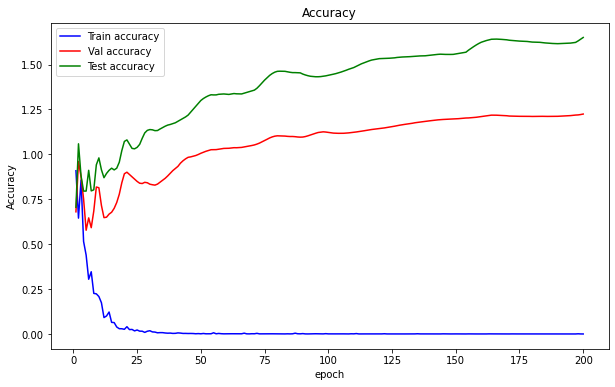

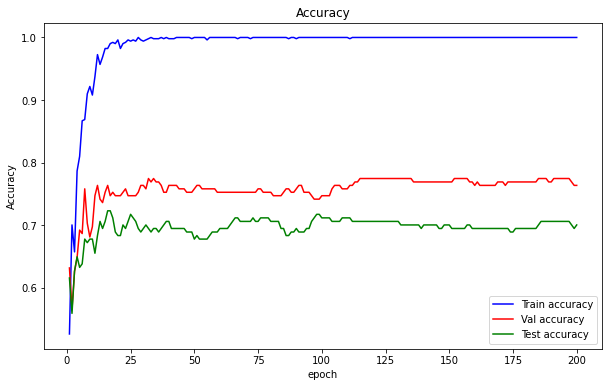



In fold  1
The best validaiton accuracy is:  0.7747252747252747
Happened at epoch:  197
The corresponding test accuracy 0.7062146892655368
The corresponding test AUC is:  0.7836317135549872




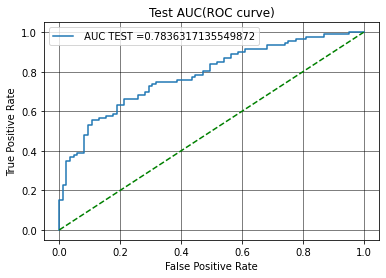

  + Number of params: 1569538
Save models
Train Epoch: 1: train loss : 0.94503927	 train accuracy : 0.48554913	 val accuracy : 0.54802260	 test accuracy : 0.56321839	
Train Epoch: 2: train loss : 1.50361180	 train accuracy : 0.58188825	 val accuracy : 0.54237288	 test accuracy : 0.50574713	
Save models
Train Epoch: 3: train loss : 1.29091454	 train accuracy : 0.58959538	 val accuracy : 0.61581921	 test accuracy : 0.63218391	
Train Epoch: 4: train loss : 0.63807768	 train accuracy : 0.71290944	 val accuracy : 0.54237288	 test accuracy : 0.55172414	
Train Epoch: 5: train loss : 0.84717035	 train accuracy : 0.65317919	 val accuracy : 0.58757062	 test accuracy : 0.56321839	
Save models
Train Epoch: 6: train loss : 0.65920699	 train accuracy : 0.75915222	 val accuracy : 0.67231638	 test accuracy : 0.64367816	
Train Epoch: 7: train loss : 0.41526631	 train accuracy : 0.81695568	 val accuracy : 0.59887006	 test accuracy : 0.58620690	
Train Epoch: 8: train loss : 0.41546726	 train accuracy : 0

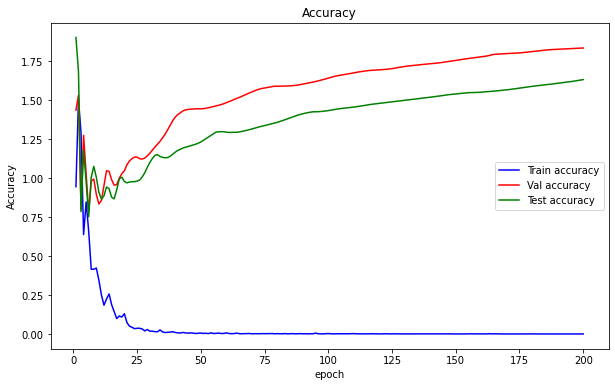

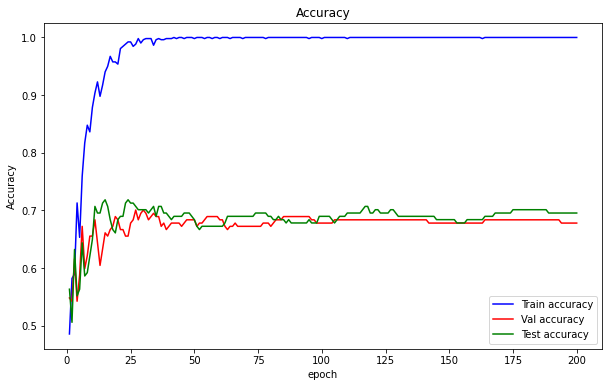



In fold  2
The best validaiton accuracy is:  0.7005649717514124
Happened at epoch:  30
The corresponding test accuracy 0.7011494252873564
The corresponding test AUC is:  0.744059471658038




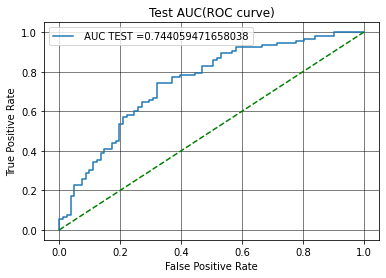

  + Number of params: 1569538
Save models
Train Epoch: 1: train loss : 0.94386899	 train accuracy : 0.50570342	 val accuracy : 0.55747126	 test accuracy : 0.48823529	
Save models
Train Epoch: 2: train loss : 1.20042253	 train accuracy : 0.58365019	 val accuracy : 0.61494253	 test accuracy : 0.63529412	
Train Epoch: 3: train loss : 0.58876252	 train accuracy : 0.71102662	 val accuracy : 0.56896552	 test accuracy : 0.59411765	
Save models
Train Epoch: 4: train loss : 0.63408458	 train accuracy : 0.73384030	 val accuracy : 0.62068966	 test accuracy : 0.66470588	
Save models
Train Epoch: 5: train loss : 0.45101631	 train accuracy : 0.81368821	 val accuracy : 0.64942529	 test accuracy : 0.60588235	
Save models
Train Epoch: 6: train loss : 0.42510730	 train accuracy : 0.80988593	 val accuracy : 0.66666667	 test accuracy : 0.60588235	
Train Epoch: 7: train loss : 0.36291221	 train accuracy : 0.85171103	 val accuracy : 0.63793103	 test accuracy : 0.60000000	
Save models
Train Epoch: 8: train l

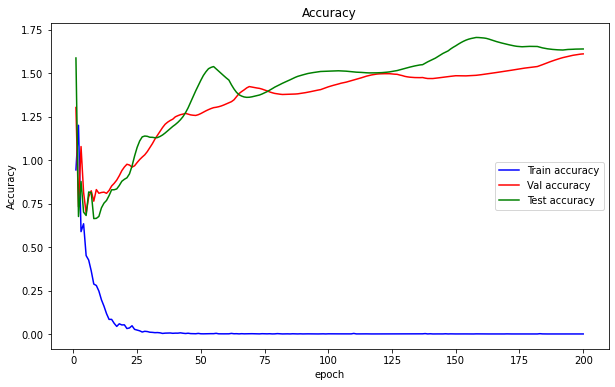

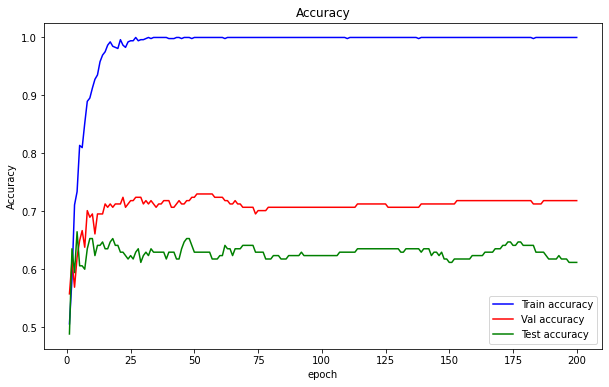



In fold  3
The best validaiton accuracy is:  0.7298850574712644
Happened at epoch:  57
The corresponding test accuracy 0.6176470588235294
The corresponding test AUC is:  0.7036674132138858




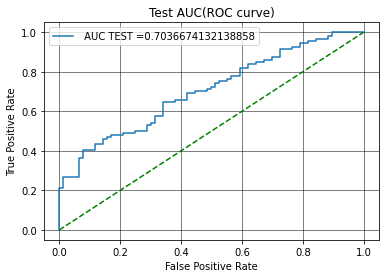

  + Number of params: 1569538
Save models
Train Epoch: 1: train loss : 1.06346869	 train accuracy : 0.49906191	 val accuracy : 0.45294118	 test accuracy : 0.44311377	
Save models
Train Epoch: 2: train loss : 1.27109885	 train accuracy : 0.51031895	 val accuracy : 0.55882353	 test accuracy : 0.55089820	
Save models
Train Epoch: 3: train loss : 1.77438259	 train accuracy : 0.55722326	 val accuracy : 0.60588235	 test accuracy : 0.64071856	
Train Epoch: 4: train loss : 0.80622101	 train accuracy : 0.70168856	 val accuracy : 0.55882353	 test accuracy : 0.59281437	
Train Epoch: 5: train loss : 1.02364922	 train accuracy : 0.67166979	 val accuracy : 0.54117647	 test accuracy : 0.60479042	
Save models
Train Epoch: 6: train loss : 0.86478931	 train accuracy : 0.71106942	 val accuracy : 0.64705882	 test accuracy : 0.67664671	
Save models
Train Epoch: 7: train loss : 0.45155150	 train accuracy : 0.81988743	 val accuracy : 0.64705882	 test accuracy : 0.68862275	
Train Epoch: 8: train loss : 0.4585

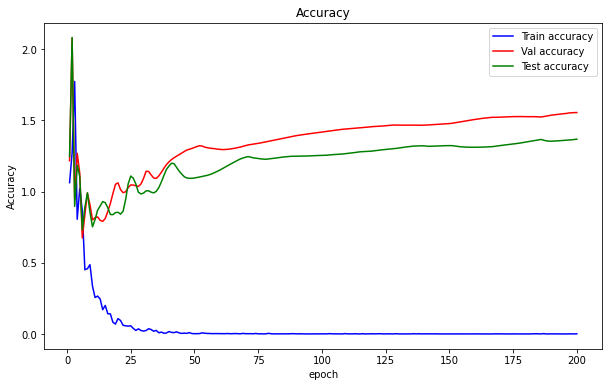

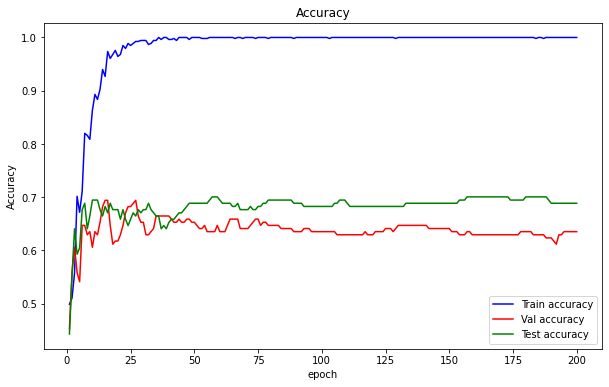



In fold  4
The best validaiton accuracy is:  0.6941176470588235
Happened at epoch:  27
The corresponding test accuracy 0.6646706586826348
The corresponding test AUC is:  0.7373913043478261




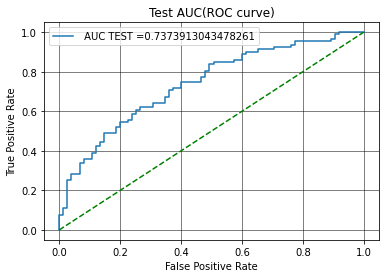

  + Number of params: 1569538
Save models
Train Epoch: 1: train loss : 1.43194044	 train accuracy : 0.52975048	 val accuracy : 0.50299401	 test accuracy : 0.54395604	
Save models
Train Epoch: 2: train loss : 0.90556467	 train accuracy : 0.62380038	 val accuracy : 0.55688623	 test accuracy : 0.52197802	
Save models
Train Epoch: 3: train loss : 1.57607651	 train accuracy : 0.56621881	 val accuracy : 0.57485030	 test accuracy : 0.57142857	
Save models
Train Epoch: 4: train loss : 0.98932904	 train accuracy : 0.66602687	 val accuracy : 0.59281437	 test accuracy : 0.61538462	
Save models
Train Epoch: 5: train loss : 0.83221108	 train accuracy : 0.67370441	 val accuracy : 0.64071856	 test accuracy : 0.63736264	
Train Epoch: 6: train loss : 0.57556403	 train accuracy : 0.79078695	 val accuracy : 0.61077844	 test accuracy : 0.62087912	
Train Epoch: 7: train loss : 0.69651800	 train accuracy : 0.76967370	 val accuracy : 0.61676647	 test accuracy : 0.62087912	
Save models
Train Epoch: 8: train l

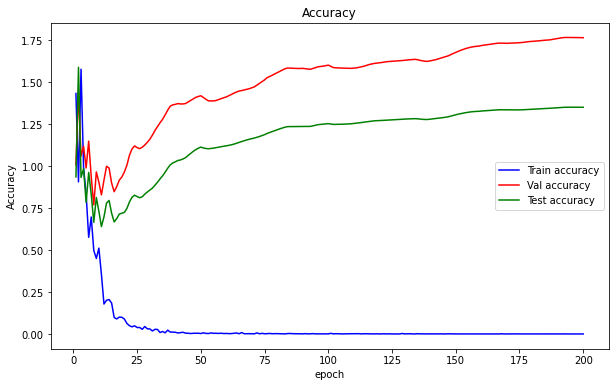

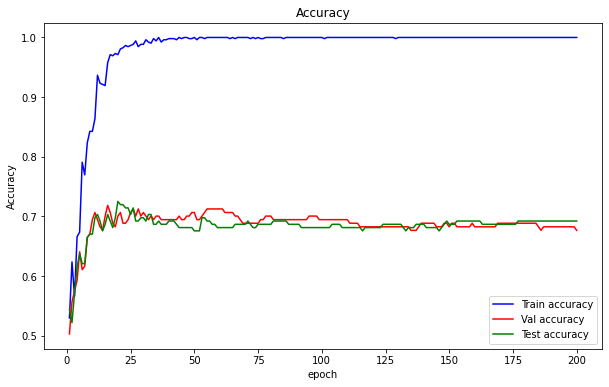



In fold  5
The best validaiton accuracy is:  0.718562874251497
Happened at epoch:  16
The corresponding test accuracy 0.7032967032967034
The corresponding test AUC is:  0.7942102713178295




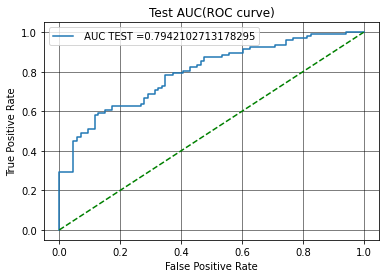

Finish 5-fold training


In [ ]:
########################################### Training ################################################
########################################### Training ################################################
########################################### Training ################################################
for fold in range(1, k_fold+1):
  
  model = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
  print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
  model = nn.parallel.DataParallel(model, device_ids=gpu_ids)
  if args.cuda:
    model = model.cuda()
  optimizer = optim.Adam(model.parameters(), lr = args.lr)

  best_validation_accuracy = 0
  Train_accuracy_list =[]
  Train_loss_list = []
  Val_accuracy_list =[]
  Val_loss_list = []
  Test_accuracy_list =[]
  Test_loss_list = []

  for epoch in range(1, args.nEpochs + 1):

    model, train_target, train_out, train_loss, val_target, val_out, val_loss, test_target, test_out, test_prob, test_loss = train(args, model, data[str(fold)], dist_train[str(fold)], dist_validation[str(fold)], dist_test[str(fold)], optimizer)

    train_accuracy = metrics.accuracy_score(train_target, train_out)
    val_accuracy = metrics.accuracy_score(val_target, val_out)
    test_accuracy = metrics.accuracy_score(test_target, test_out)
    Train_accuracy_list.append(train_accuracy)
    Val_accuracy_list.append(val_accuracy)
    Test_accuracy_list.append(test_accuracy)
    Train_loss_list.append(train_loss)
    Val_loss_list.append(val_loss)
    Test_loss_list.append(test_loss)

    if val_accuracy >=best_validation_accuracy:
      best_epoch = epoch
      best_validation_accuracy = val_accuracy
      corresponding_val_out = val_out
      corresponding_test_accuracy = test_accuracy
      corresponding_test_out = test_out
      corresponding_test_prob = test_prob

      print('Save models')
      save_model(model, save_path, 'GCN_'+str(fold))

    print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
      train_loss, train_accuracy, val_accuracy, test_accuracy))
    # model = load_model(model, save_path, 'GCN_' + str(fold))
    # target, out, out_prob, cross_loss = test_test(args, model, data[str(fold)], dist_test[str(fold)])
    # test_accuracy = metrics.accuracy_score(target, out)
    # print(test_accuracy)
  
  if fold == 1:
    all_fold_val_label = val_target
    all_fold_val_out = corresponding_val_out
    all_fold_test_label = test_target
    all_fold_test_out = corresponding_test_out
    all_fold_test_prob = corresponding_test_prob
  else:
    all_fold_val_label = np.concatenate((all_fold_val_label, val_target),axis = 0)
    all_fold_val_out = np.concatenate((all_fold_val_out, corresponding_val_out),axis = 0)
    all_fold_test_label = np.concatenate((all_fold_test_label, test_target),axis = 0)
    all_fold_test_out = np.concatenate((all_fold_test_out, corresponding_test_out),axis = 0)
    all_fold_test_prob = np.concatenate((all_fold_test_prob, corresponding_test_prob),axis = 0)

  x_axis = list(range(1, len(Train_accuracy_list)+1))
  plt.figure(figsize=(10,6))
  plt.plot(x_axis, Train_loss_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_loss_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_loss_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,6))
  plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()


  test_fpr, test_tpr, te_thresholds = roc_curve(test_target, corresponding_test_prob[:,1],pos_label=1)
  test_auc = auc(test_fpr, test_tpr)
  print('\n')
  print('In fold ',str(fold))
  print('The best validaiton accuracy is: ',best_validation_accuracy)
  print('Happened at epoch: ',best_epoch)
  print('The corresponding test accuracy', corresponding_test_accuracy)
  print('The corresponding test AUC is: ',test_auc)
  print('\n')


  plt.grid()
  plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Test AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()

print('Finish 5-fold training')


The best validation accuracy is  0.7241379310344828
The corresponding test accuracy is  0.6793103448275862
The corresponding test AUC is:  0.7433541798396395


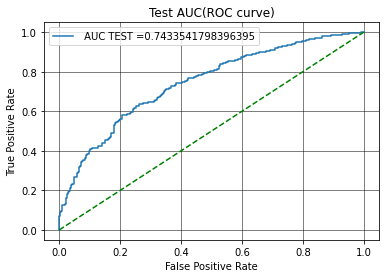

In [ ]:
val_accuracy = metrics.accuracy_score(all_fold_val_label, all_fold_val_out)
test_accuracy = metrics.accuracy_score(all_fold_test_label, all_fold_test_out)
test_fpr, test_tpr, te_thresholds = roc_curve(all_fold_test_label, all_fold_test_prob[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The best validation accuracy is ',val_accuracy)
print('The corresponding test accuracy is ',test_accuracy)
print('The corresponding test AUC is: ',test_auc)
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

Ensemble  1
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

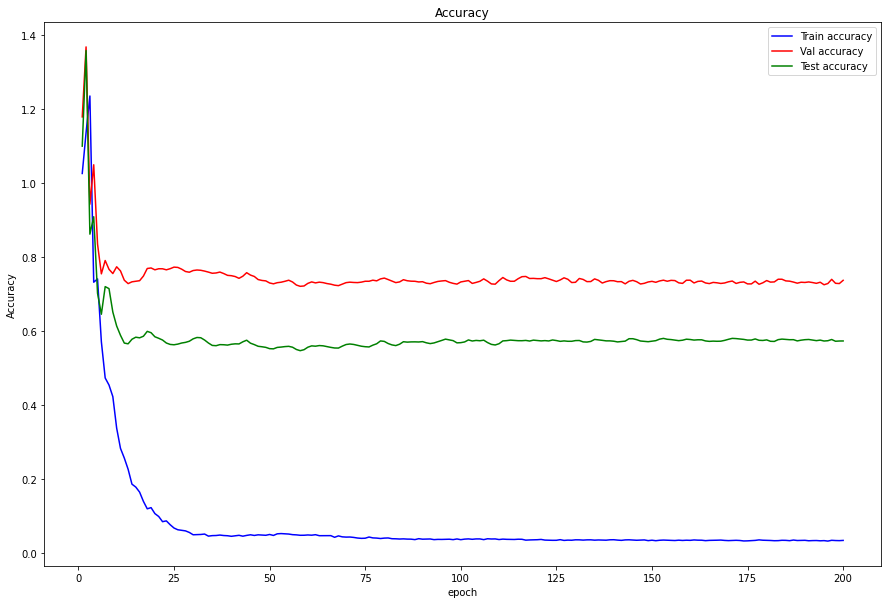

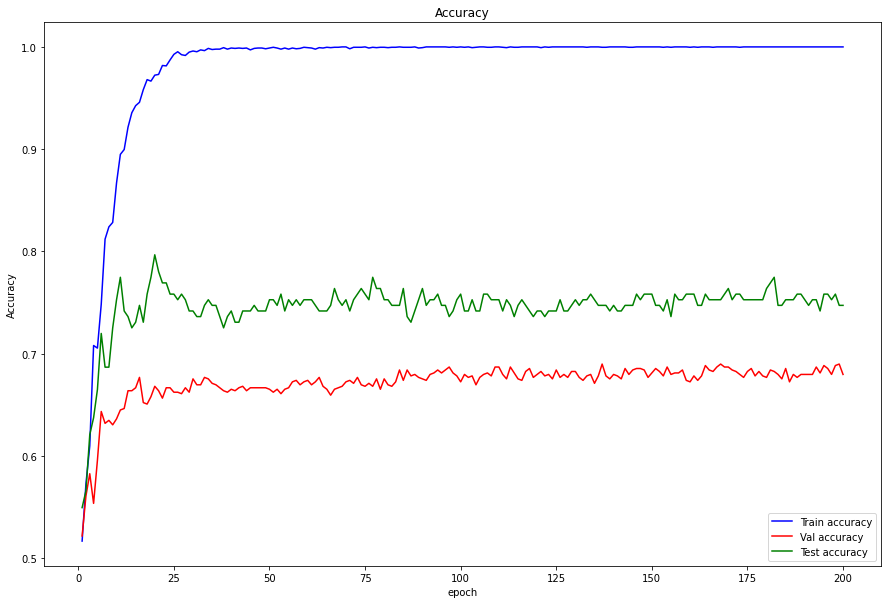



In ensemble  1
The best validaiton accuracy is:  0.6898550724637681
Happened at epoch:  199
The corresponding test accuracy 0.7472527472527473
The corresponding test AUC is:  0.8391472868217055




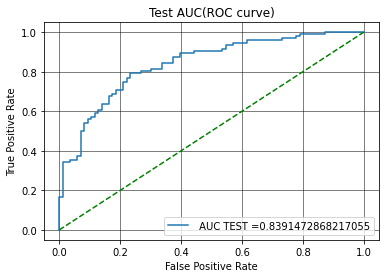



Ensemble  2
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

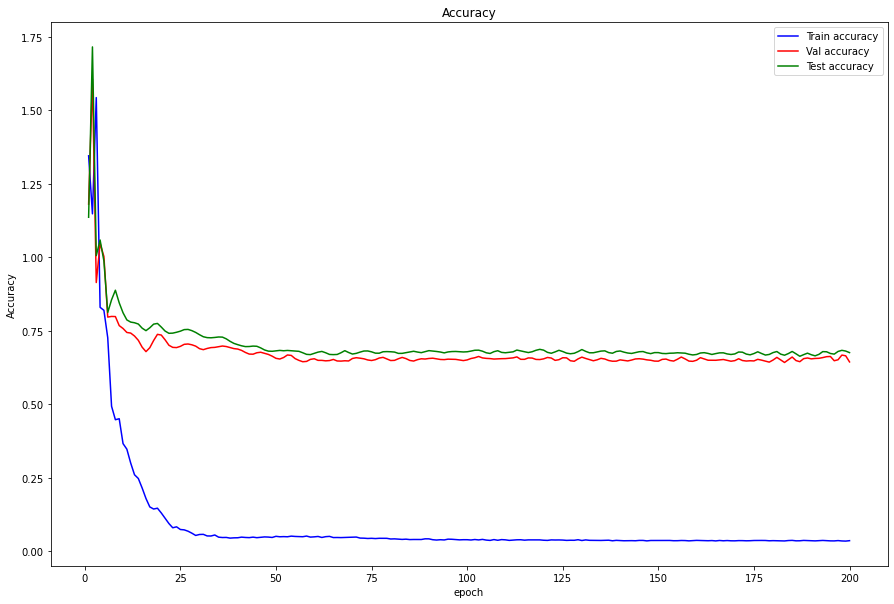

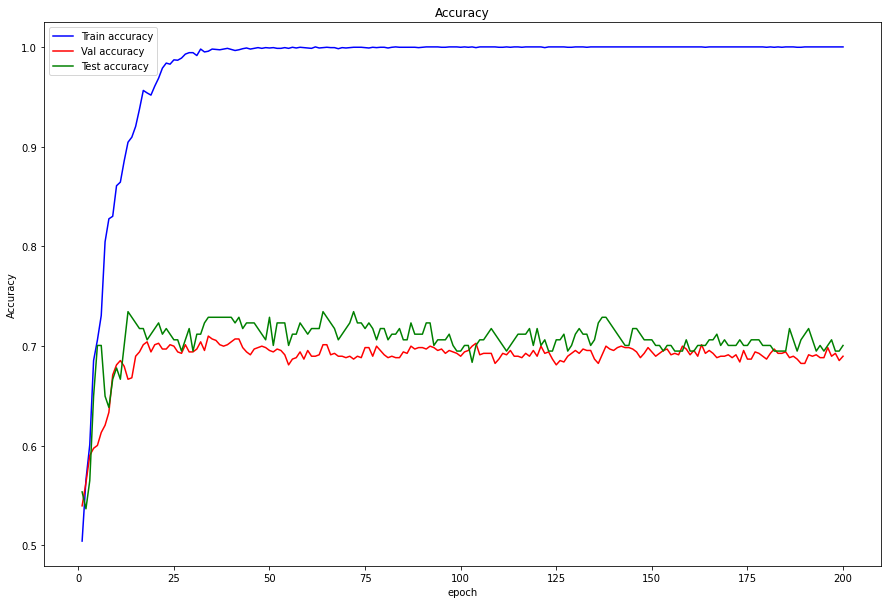



In ensemble  2
The best validaiton accuracy is:  0.70995670995671
Happened at epoch:  34
The corresponding test accuracy 0.7288135593220338
The corresponding test AUC is:  0.7840153452685422




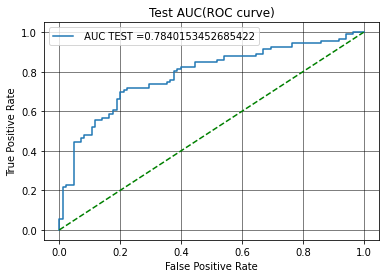



Ensemble  3


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

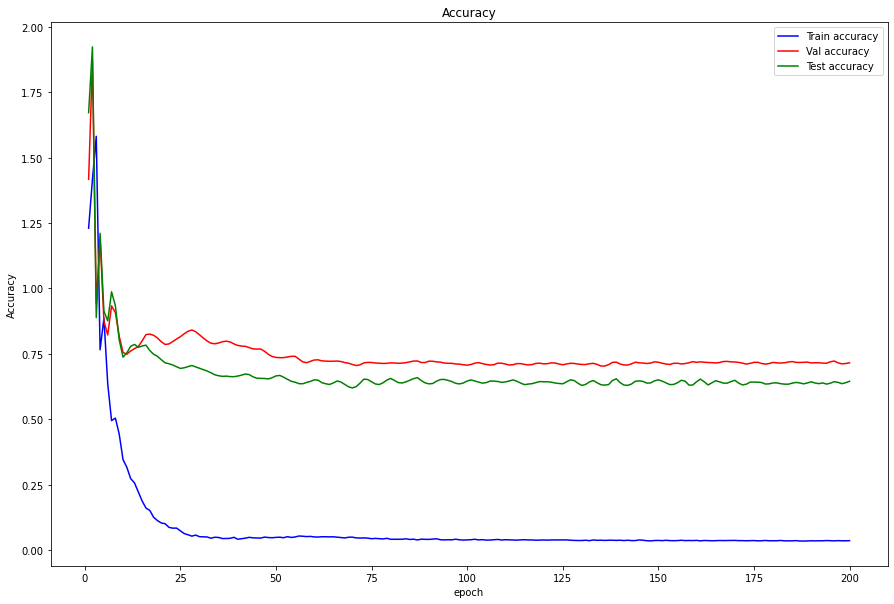

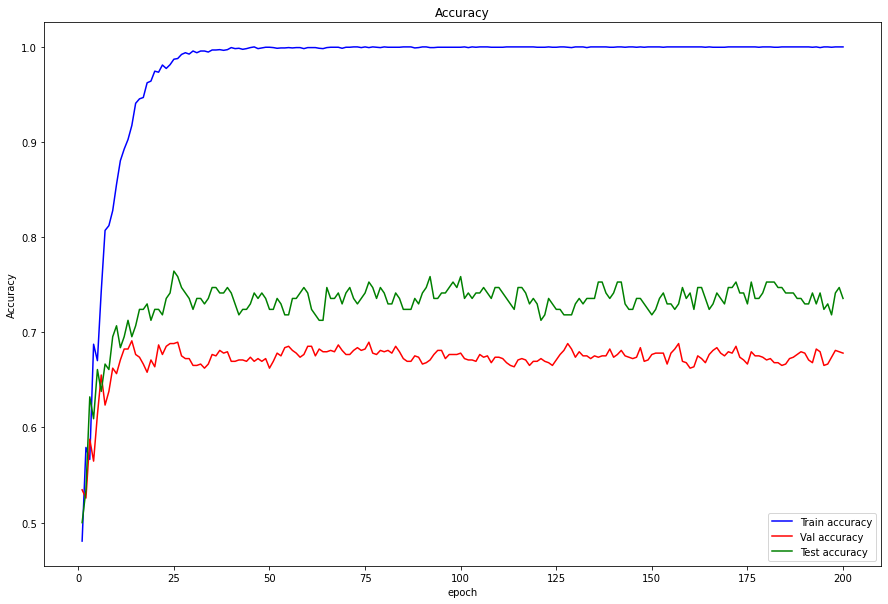



In ensemble  3
The best validaiton accuracy is:  0.6910919540229885
Happened at epoch:  14
The corresponding test accuracy 0.6954022988505747
The corresponding test AUC is:  0.7635736094517457




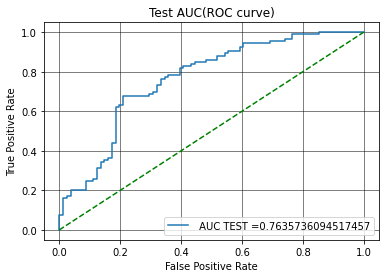



Ensemble  4
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

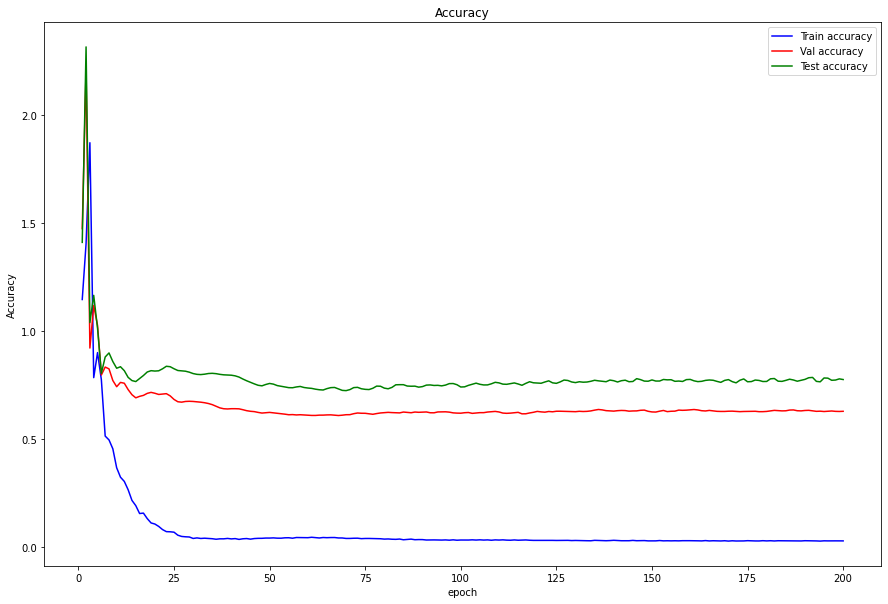

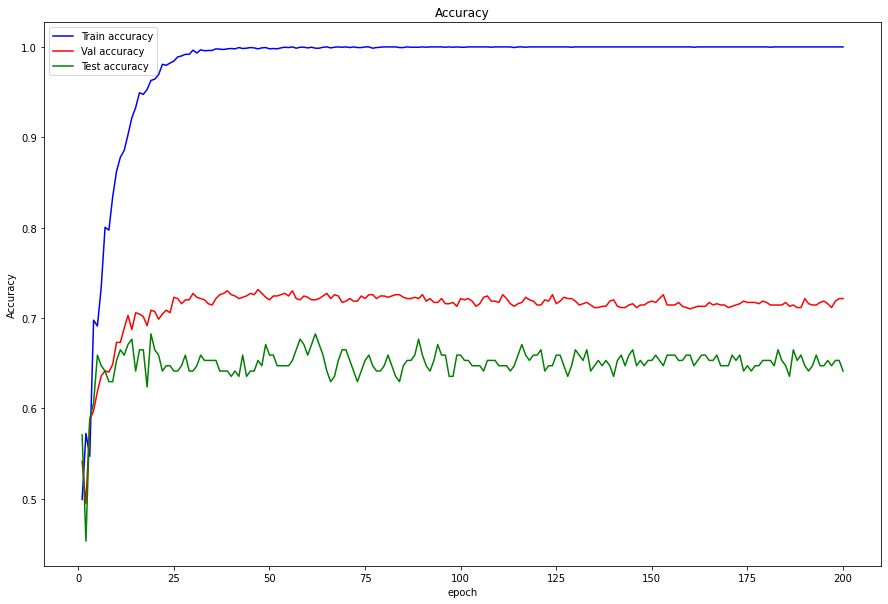



In ensemble  4
The best validaiton accuracy is:  0.7314285714285714
Happened at epoch:  47
The corresponding test accuracy 0.6529411764705882
The corresponding test AUC is:  0.7403415453527435




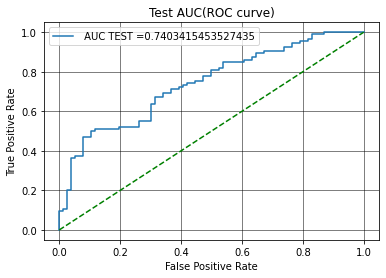



Ensemble  5
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

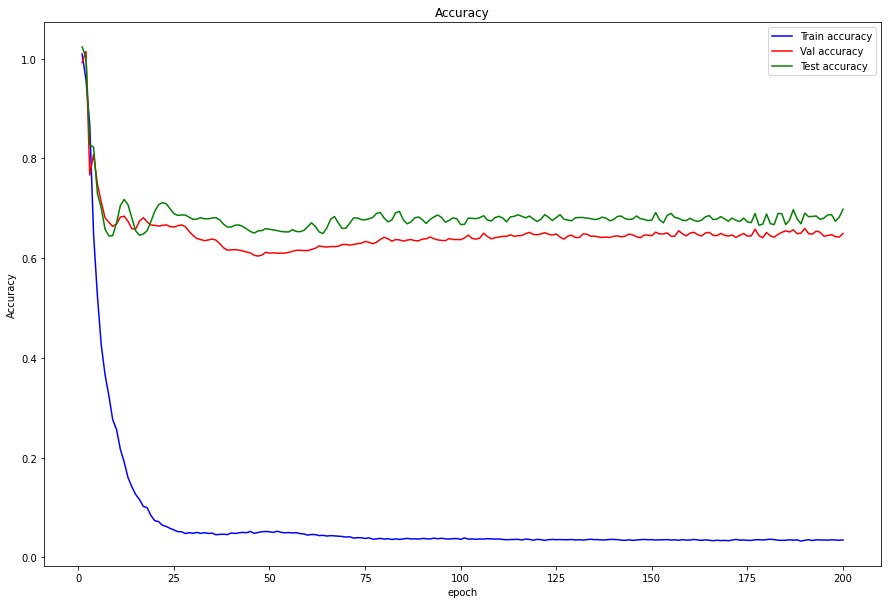

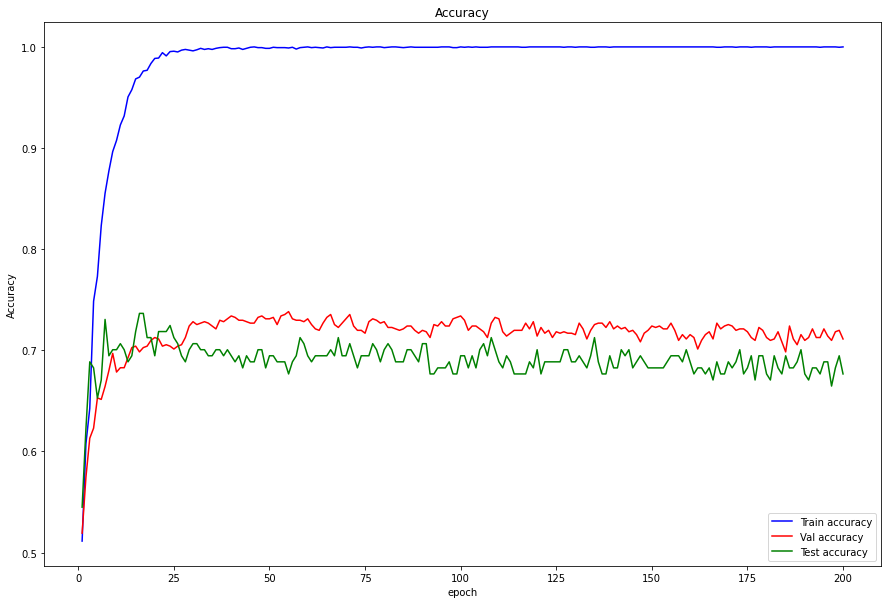



In ensemble  5
The best validaiton accuracy is:  0.7382645803698435
Happened at epoch:  55
The corresponding test accuracy 0.6766467065868264
The corresponding test AUC is:  0.7920289855072463




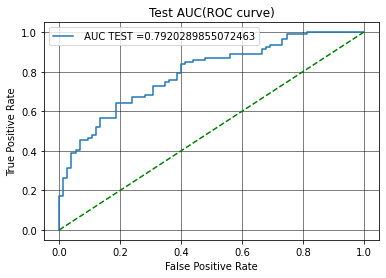



The Max voting test accuracy is:  0.7011494252873564
The test AUC is:  0.7833805346411549






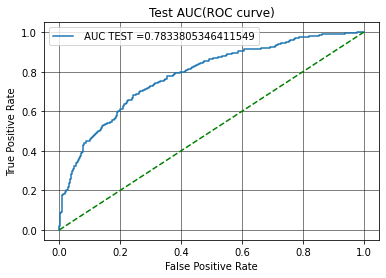

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
dist_ensemble_val_label = {}
dist_ensemble_val_result = {}
dist_ensemble_test_label = {}
dist_ensemble_test_result = {}
dist_ensemble_test_prob = {}

for ensemble_fold in range(5):
  print('Ensemble ',ensemble_fold+1)
  save_ensemble_models_path = save_path + 'Max_voting/GCN/'
  dist_train = {}
  dist_validation = {}
  dist_test = {}
  for i in range(k_fold):
    dist_train[str(i + 1)] = []
    dist_validation[str(i + 1)] = []
    dist_test[str(i + 1)] = []
  test_name = {}
  for i in range(len(unique_sites)):
    test_name[unique_sites[i]] = []
  for each_site in unique_sites:
    index_site = get_index(sites, each_site)
    label = np.zeros((len(index_site)))
    for i in range(len(index_site)):
      index = index_site[i]
      label[i] = int(labels[int(index)])
    test_name_list = test_name[each_site]
    ########################################### StratifiedKFold ####################################################
    sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
    group = 0
    for train, validation in sfolder.split(index_site,label):
      if group == ensemble_fold:
        for j in validation:
          name = index_site[j]
          dist_test['1'].append(name)
          dist_test['2'].append(name)
          dist_test['3'].append(name)
          dist_test['4'].append(name)
          dist_test['5'].append(name)
          test_name_list.append(name)
      group = group + 1
    test_name[each_site] = test_name_list

  for each_site in unique_sites:
    if ensemble_fold == 0:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      if each_site == 'CMU':  # ONLY 4 AUTISM SAMPLES AND 4 TD SAMPLES, CAN NOT BE DEVIDED INTO 5 GROUPS
        group_autism_val = []
        group_autism_train = []
        group_TD_val = []
        group_TD_train = []
        autism_validation_number = len(label_new[label_new ==1])/4
        TD_validation_number = len(label_new[label_new ==0]) / 4
        for j in range(len(label_new)):
          if label_new[j] == 1:
            if len(group_autism_val)<autism_validation_number:
              group_autism_val.append(index_site_new[j])
            else:
              group_autism_train.append(index_site_new[j])
          else:
            if len(group_TD_val)<TD_validation_number:
              group_TD_val.append(index_site_new[j])
            else:
              group_TD_train.append(index_site_new[j])

        dist_validation['1'] = dist_validation['1'] + group_autism_val + group_TD_val
        dist_validation['2'] = dist_validation['2'] + group_autism_val + group_TD_val
        dist_validation['3'] = dist_validation['3'] + group_autism_val + group_TD_val
        dist_validation['4'] = dist_validation['4'] + group_autism_val + group_TD_val
        dist_validation['5'] = dist_validation['5'] + group_autism_val + group_TD_val
        dist_train['1'] = dist_train['1'] + group_autism_train + group_TD_train
        dist_train['2'] = dist_train['2'] + group_autism_train + group_TD_train
        dist_train['3'] = dist_train['3'] + group_autism_train + group_TD_train
        dist_train['4'] = dist_train['4'] + group_autism_train + group_TD_train
        dist_train['5'] = dist_train['5'] + group_autism_train + group_TD_train
      else:
        ########################################### StratifiedKFold ####################################################
        sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
        group = 0
        for train, validation in sfolder.split(index_site_new, label_new):

          for i in train:
            name = index_site_new[i]
            dist_train[str(group + 1)].append(name)
          for j in validation:
            name = index_site_new[j]
            dist_validation[str(group + 1)].append(name)
          group = group + 1
    else:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      ########################################### StratifiedKFold ####################################################
      sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
      group = 0
      for train, validation in sfolder.split(index_site_new,label_new):

        for i in train:
          name = index_site_new[i]
          dist_train[str(group + 1)].append(name)
        for j in validation:
          name = index_site_new[j]
          dist_validation[str(group + 1)].append(name)
        group = group+1
  
  
  data = {}
  for fold in range(1, k_fold+1):
    data[str(fold)] = []
    selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
    selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

    new_fMRI_data = selector_fMRI.transform(fMRI_images)
    new_sMRI_data = selector_sMRI.transform(sMRI_features)
    ################################################# combine ##########################################
    sMRI_fMRI_combine = np.concatenate((new_sMRI_data, new_fMRI_data), axis = 1)
    selector_combine = feature_selection_fMRI(sMRI_fMRI_combine, labels, dist_train[str(fold)], new_number_features_combine)
    fold_data = selector_combine.transform(sMRI_fMRI_combine)

    n = fold_data.shape[0]
    num_edge = n * n
    edge_index = np.zeros([2, num_edge], dtype=np.int64)
    edgenet_input = np.zeros([num_edge, 1], dtype=np.float32) 
    aff_score = np.zeros(num_edge, dtype=np.float32)
    flatten_ind = 0

    for i in range(n): 
      for j in range(n):
        edge_index[:, flatten_ind] = [i, j]
        edgenet_input[flatten_ind] = graph[i,j]
        aff_score[flatten_ind] = graph[i,j]
        flatten_ind += 1


    keep_ind = np.where(aff_score > 0.99)[0]
    edge_index = edge_index[:, keep_ind]
    edgenet_input = edgenet_input[keep_ind]

    data[str(fold)].append(fold_data)
    data[str(fold)].append(GCN_labels)
    data[str(fold)].append(edge_index)
    data[str(fold)].append(edgenet_input)




  ############################################### Train ###############################################################
  ############################################### Train ###############################################################
  ############################################### Train ###############################################################

  model_1 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
  model_2 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
  model_3 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
  model_4 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
  model_5 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)

  gpu_ids = range(args.ngpu)
  model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
  model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
  model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
  model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
  model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)
  train = train_GCN

  print('  + Number of params: {}'.format(
      sum([p.data.nelement() for p in model_1.parameters()])))
  if args.cuda:
      model_1 = model_1.cuda()
      model_2 = model_2.cuda()
      model_3 = model_3.cuda()
      model_4 = model_4.cuda()
      model_5 = model_5.cuda()

  optimizer_1 = optim.Adam(model_1.parameters(), lr = args.lr, weight_decay=0.1)
  optimizer_2 = optim.Adam(model_2.parameters(), lr = args.lr, weight_decay=0.1)
  optimizer_3 = optim.Adam(model_3.parameters(), lr = args.lr, weight_decay=0.1)
  optimizer_4 = optim.Adam(model_4.parameters(), lr = args.lr, weight_decay=0.1)
  optimizer_5 = optim.Adam(model_5.parameters(), lr = args.lr, weight_decay=0.1)

  Train_accuracy_list =[]
  Train_loss_list = []
  Val_accuracy_list =[]
  Val_loss_list = []
  Test_accuracy_list =[]
  Test_loss_list = []
  best_validation_accuracy = 0

  for epoch in range(1, args.nEpochs + 1):


    model_1, train_target_1, train_out_1, train_loss_1, val_target_1, val_out_1, val_loss_1, test_target_1, test_out_1, test_prob_1, test_loss_1 = train(args, model_1, data['1'], dist_train['1'], dist_validation['1'], dist_test['1'], optimizer_1)
    model_2, train_target_2, train_out_2, train_loss_2, val_target_2, val_out_2, val_loss_2, test_target_2, test_out_2, test_prob_2, test_loss_2 = train(args, model_2, data['2'], dist_train['2'], dist_validation['2'], dist_test['2'], optimizer_2)
    model_3, train_target_3, train_out_3, train_loss_3, val_target_3, val_out_3, val_loss_3, test_target_3, test_out_3, test_prob_3, test_loss_3 = train(args, model_3, data['3'], dist_train['3'], dist_validation['3'], dist_test['3'], optimizer_3)
    model_4, train_target_4, train_out_4, train_loss_4, val_target_4, val_out_4, val_loss_4, test_target_4, test_out_4, test_prob_4, test_loss_4 = train(args, model_4, data['4'], dist_train['4'], dist_validation['4'], dist_test['4'], optimizer_4)
    model_5, train_target_5, train_out_5, train_loss_5, val_target_5, val_out_5, val_loss_5, test_target_5, test_out_5, test_prob_5, test_loss_5 = train(args, model_5, data['5'], dist_train['5'], dist_validation['5'], dist_test['5'], optimizer_5)

    train_target_all = np.concatenate((train_target_1, train_target_2, train_target_3, train_target_4, train_target_5),axis = 0)
    train_out_all = np.concatenate((train_out_1, train_out_2, train_out_3, train_out_4, train_out_5),axis = 0)
    train_loss = (train_loss_1 + train_loss_2 + train_loss_3 + train_loss_4 + train_loss_5)/5
    val_target_all = np.concatenate((val_target_1, val_target_2, val_target_3, val_target_4, val_target_5),axis = 0)
    val_out_all = np.concatenate((val_out_1, val_out_2, val_out_3, val_out_4, val_out_5),axis = 0)
    val_loss = (val_loss_1 + val_loss_2 + val_loss_3 + val_loss_4 + val_loss_5)/5
    test_target_all = test_target_1 # test_target_1 = test_target_2 = test_target_3 = test_target_4 = test_target_5
    test_out_all = test_out_1 + test_out_2 + test_out_3 + test_out_4 + test_out_5
    test_prob_all = (test_prob_1 + test_prob_2 + test_prob_3 + test_prob_4 + test_prob_5)/5
    test_loss = (test_loss_1 + test_loss_2 + test_loss_3 + test_loss_4 + test_loss_5)/5

    test_results_binary = np.zeros_like((test_out_all))
    test_results_binary[test_out_all<2.5] = 0
    test_results_binary[test_out_all>=2.5] = 1

    train_accuracy = metrics.accuracy_score(train_target_all, train_out_all)
    val_accuracy = metrics.accuracy_score(val_target_all, val_out_all)
    test_accuracy = metrics.accuracy_score(test_target_all, test_results_binary)
    Train_accuracy_list.append(train_accuracy)
    Val_accuracy_list.append(val_accuracy)
    Test_accuracy_list.append(test_accuracy)
    Train_loss_list.append(train_loss)
    Val_loss_list.append(val_loss)
    Test_loss_list.append(test_loss)

    if val_accuracy >=best_validation_accuracy:
      best_epoch = epoch
      best_validation_accuracy = val_accuracy
      corresponding_test_accuracy = test_accuracy
      corresponding_test_prob = test_prob_all
      corresponding_test_labels = test_target_all
      corresponding_test_out = test_results_binary
      print('Save models')

      save_model(model_1, save_ensemble_models_path, 'GCN_ensemble' + str(ensemble_fold) + '_1')
      save_model(model_2, save_ensemble_models_path, 'GCN_ensemble' + str(ensemble_fold) + '_2')
      save_model(model_3, save_ensemble_models_path, 'GCN_ensemble' + str(ensemble_fold) + '_3')
      save_model(model_4, save_ensemble_models_path, 'GCN_ensemble' + str(ensemble_fold) + '_4')
      save_model(model_5, save_ensemble_models_path, 'GCN_ensemble' + str(ensemble_fold) + '_5')

    print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
      train_loss, train_accuracy, val_accuracy, test_accuracy))

  x_axis = list(range(1, len(Train_accuracy_list)+1))
  plt.figure(figsize=(15,10))
  plt.plot(x_axis, Train_loss_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_loss_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_loss_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(15,10))
  plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()
 
  test_fpr, test_tpr, te_thresholds = roc_curve(corresponding_test_labels, corresponding_test_prob[:,1],pos_label=1)
  test_auc = auc(test_fpr, test_tpr)
  print('\n')
  print('In ensemble ',ensemble_fold+1)
  print('The best validaiton accuracy is: ',best_validation_accuracy)
  print('Happened at epoch: ',best_epoch)
  print('The corresponding test accuracy', corresponding_test_accuracy)
  print('The corresponding test AUC is: ',test_auc)
  print('\n')


  plt.grid()
  plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Test AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()


  dist_ensemble_test_label[str(ensemble_fold+1)] = corresponding_test_labels
  dist_ensemble_test_result[str(ensemble_fold+1)] = corresponding_test_out
  dist_ensemble_test_prob[str(ensemble_fold+1)] = corresponding_test_prob
  print('\n')

  torch.cuda.empty_cache()

test_labels_concat = np.concatenate((dist_ensemble_test_label['1'], dist_ensemble_test_label['2'],  dist_ensemble_test_label['3'], dist_ensemble_test_label['4'], dist_ensemble_test_label['5']),axis = 0)
test_results_concat = np.concatenate((dist_ensemble_test_result['1'], dist_ensemble_test_result['2'],  dist_ensemble_test_result['3'], dist_ensemble_test_result['4'], dist_ensemble_test_result['5']),axis = 0)
test_probs_concat = np.concatenate((dist_ensemble_test_prob['1'], dist_ensemble_test_prob['2'],  dist_ensemble_test_prob['3'], dist_ensemble_test_prob['4'], dist_ensemble_test_prob['5']),axis = 0)

test_accuracy = metrics.accuracy_score(test_labels_concat, test_results_concat)
test_fpr, test_tpr, te_thresholds = roc_curve(test_labels_concat, test_probs_concat[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The Max voting test accuracy is: ',test_accuracy)
print('The test AUC is: ',test_auc)

print('\n')
print('\n')
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

